In [1]:
import jax
import jax.numpy as np
from jax import linear_util as lu
from jax.flatten_util import ravel_pytree
import numpy as onp
from functools import partial
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys

# Define dynamical system

In [2]:
def Lorenz_rhs_func(state, t, ode_params):
    rho, sigma, beta = ode_params
    x, y, z = state
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


# About the decorator: f is a function (not JAX array) and JAX needs to know that so we specify it as "static"
@partial(jax.jit, static_argnums=(2,))
def rk4(state, t_crt, f, ode_params):
    y_prev, t_prev = state
    h = t_crt - t_prev
    k1 = h * f(y_prev, t_prev, ode_params)
    k2 = h * f(y_prev + k1/2., t_prev + h/2., ode_params)
    k3 = h * f(y_prev + k2/2., t_prev + h/2., ode_params)
    k4 = h * f(y_prev + k3, t_prev + h, ode_params)
    y_crt = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return (y_crt, t_crt), y_crt


def odeint(stepper, f, y0, ts, ode_params):

    def stepper_partial(state, t_crt):
        return stepper(state, t_crt, f, ode_params)

    ys = []
    state = (y0, ts[0])
    for (i, t_crt) in enumerate(ts[1:]):
        state, y = stepper_partial(state, t_crt)
        ys.append(y)
    ys = np.array(ys)
    return ys

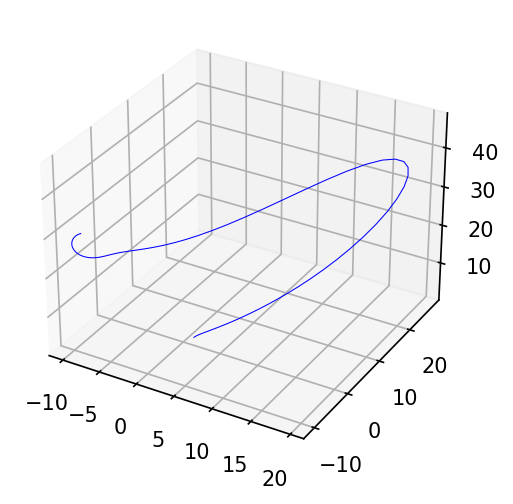

In [3]:
y0 = np.array([1., 1., 1.])
dt = 1e-2
ts = np.arange(0, 101*dt, dt)

ode_params_gt = [28., 10., 8./3.]

ys_gt_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_gt)
ys_gt = np.vstack((y0[None, ...], ys_gt_))

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys_gt.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

# Compute derivatives with several methods

In [4]:
def compute_gradient_fd(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running finite difference")
    
    y0 = ys[0]
    h = 1e-1
    ode_params_flat, unravel = ravel_pytree(ode_params)

    grads = []
    for i in range(len(ode_params_flat)):
        ode_params_flat_plus = ode_params_flat.at[i].add(h)
        ys_plus_ = odeint(rk4, state_rhs_func, y0, ts, unravel(ode_params_flat_plus))
        tau_plus = obj_func(ys_plus_[-1])
        
        ode_params_flat_minus = ode_params_flat.at[i].add(-h)
        ys_minus_ = odeint(rk4, state_rhs_func, y0, ts, unravel(ode_params_flat_minus))
        tau_minus = obj_func(ys_minus_[-1])

        grad = (tau_plus - tau_minus) / (2 * h)
        grads.append(grad)

    grads = unravel(np.array(grads))

    return grads


def compute_gradient_ad_diff_through_loops(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running autodiff, differentiate through loops")

    y0 = ys[0]
    def func(ode_params):
        ys_ = odeint(rk4, state_rhs_func, y0, ts, ode_params)
        return obj_func(ys_[-1])
    grad_func = jax.grad(func)
    grads = grad_func(ode_params)
    
    return grads


def compute_gradient_ad_early_discretization(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running autodiff, early discretization")
    
    rev_ts = ts[::-1]
    rev_ys = ys[::-1]
    init_cond_adjoint, ode_params_adjoint = jax.grad(obj_func)(rev_ys[0]), jax.tree_map(np.zeros_like, ode_params)
    init_cond_adjoints = [init_cond_adjoint]
    ode_params_adjoints = [ode_params_adjoint]

    @jax.jit
    def adjoint_fn(y_prev, t_prev, t_crt, init_cond_adjoint, ode_params_adjoint):
        y_dot, vjpfun = jax.vjp(lambda y_prev, ode_params: rk4((y_prev, t_prev), t_crt, state_rhs_func, ode_params)[1], y_prev, ode_params)
        init_cond_adjoint_new, ode_params_adjoint_tmp = vjpfun(init_cond_adjoint)  
        ode_params_adjoint_new = jax.tree_util.tree_map(lambda x, y: x + y, ode_params_adjoint_tmp, ode_params_adjoint)
        return init_cond_adjoint_new, ode_params_adjoint_new

    for i in range(len(ts) - 1):
        y_prev = rev_ys[i + 1]
        t_prev = rev_ts[i + 1]
        y_crt = rev_ys[i]
        t_crt = rev_ts[i]
        init_cond_adjoint, ode_params_adjoint = adjoint_fn(y_prev, t_prev, t_crt, init_cond_adjoint, ode_params_adjoint)

    grads = ode_params_adjoint

    return grads


def compute_gradient_ad_late_discretization(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running autodiff, late discretization")
    # Only yf is needed, we actually don't need the entire trajectories of ys
    yf = ys[-1]

    def ravel_f(func, unravel):
        def modified_f(raveled_aug, t, args):
            aug = unravel(raveled_aug)
            rhs, _ = ravel_pytree(func(aug, t, args))
            return rhs
        return modified_f

    def odeint_ravelled(stepper, f, y0, ts, ode_params):
        y0, unravel = ravel_pytree(y0)
        f = ravel_f(f, unravel)
        out = odeint(stepper, f, y0, ts, ode_params)
        return jax.vmap(unravel)(out)

    def get_aug_rhs_func(state_rhs_func):
        def aug_rhs_func(aug, neg_t, aug_args):
            y, init_cond_adjoint, ode_params_adjoint = aug
            y_dot, vjpfun = jax.vjp(lambda y, ode_params: state_rhs_func(y, -neg_t, ode_params), y, ode_params)
            init_cond_adjoint_dot, ode_params_adjoint_dot = vjpfun(init_cond_adjoint)
            return (-y_dot, init_cond_adjoint_dot, ode_params_adjoint_dot)

        return aug_rhs_func
    
    aug0 = (yf, jax.grad(obj_func)(yf), jax.tree_util.tree_map(np.zeros_like, ode_params))
    aug_rhs_func = get_aug_rhs_func(state_rhs_func)
    ys_bwd, init_cond_adjoints, ode_params_adjoints = odeint_ravelled(rk4, aug_rhs_func, aug0, -ts[::-1], [])
    grads = jax.tree_util.tree_map(lambda x: x[-1], [init_cond_adjoints, ode_params_adjoints])[1]
    
    return grads

In [5]:
def obj_func(yf, target_yf):
    return np.sum((yf - target_yf)**2)

target_yf = ys_gt_[-1]
obj_func_partial = lambda yf: obj_func(yf, target_yf)

# ode_params_0 = [np.array([26., 8., 2.])]
ode_params_0 = [26., 8., 2.]

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_0)
ys = np.vstack((y0[None, ...], ys_))

grads_fd = compute_gradient_fd(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_fd}\n")

grads_ad_diff_through_loops = compute_gradient_ad_diff_through_loops(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_ad_diff_through_loops}\n")

grads_ad_early = compute_gradient_ad_early_discretization(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_ad_early}\n")

grads_ad_late = compute_gradient_ad_late_discretization(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_ad_late}\n")


running finite difference
grads = [DeviceArray(-7.5014687, dtype=float32), DeviceArray(16.432524, dtype=float32), DeviceArray(-102.63889, dtype=float32)]

running autodiff, differentiate through loops
grads = [DeviceArray(-7.498914, dtype=float32, weak_type=True), DeviceArray(16.436684, dtype=float32, weak_type=True), DeviceArray(-102.749664, dtype=float32, weak_type=True)]

running autodiff, early discretization
grads = [DeviceArray(-7.498917, dtype=float32, weak_type=True), DeviceArray(16.436682, dtype=float32, weak_type=True), DeviceArray(-102.74966, dtype=float32, weak_type=True)]

running autodiff, late discretization
grads = [DeviceArray(-7.4988585, dtype=float32), DeviceArray(16.436718, dtype=float32), DeviceArray(-102.74866, dtype=float32)]



# Optimization

In [6]:
def optimize(ode_params_0, y0, ts, obj_func, state_rhs_func, bounds, compute_gradient_func):
    x_ini, unravel = ravel_pytree(ode_params_0)
    obj_vals = []

    def objective(x):
        print(f"\n######################### Evaluating objective value - step {objective.counter}")
        x = np.array(x)
        ode_params = unravel(x)
        ys_ = odeint(rk4, state_rhs_func, y0, ts, ode_params)
        ys = np.vstack((y0[None, ...], ys_))
        obj_val = obj_func(ys[-1])

        objective.ode_params = ode_params
        objective.ys = ys
        objective.x = ode_params

        objective.counter += 1
        obj_vals.append(obj_val)

        print(f"obj_val = {obj_val}")
        print(f"ode_params = {ode_params}")
        print(f"ys[-1] = {ys[-1]}")

        return obj_val

    def derivative(x):
        ode_params = objective.ode_params
        ys = objective.ys

        grads = compute_gradient_func(ys, ts, obj_func, state_rhs_func, ode_params)
        print(f"########################################################")
        print(f"grads = {grads}")
        print(f"########################################################")

        grads_ravelled, _ = ravel_pytree(grads)
        # 'L-BFGS-B' requires the following conversion, otherwise we get an error message saying
        # -- input not fortran contiguous -- expected elsize=8 but got 4
        return onp.array(grads_ravelled, order='F', dtype=onp.float64)

    objective.counter = 0
    options = {'maxiter': 1000, 'disp': True}  # CG or L-BFGS-B or Newton-CG or SLSQP
    res = opt.minimize(fun=objective,
                       x0=x_ini,
                       method='SLSQP',
                       jac=derivative,
                       bounds=bounds,
                       callback=None,
                       options=options)
        
    return objective.x

In [7]:
bounds = np.array([[26., 30.], [8., 12.], [8./3., 8./3.]])
ode_params_opt = optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_fd)
ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

print(f"\nGround truth parameter values = {ode_params_gt}")
print(f"Ground truth yf = {target_yf}")
print(f"\nInitial parameter values = {ode_params_0}")
print(f"Optimized parameter values = {ode_params_opt}")
print(f"Optimized yf = {ys_[-1]}")


######################### Evaluating objective value - step 0
obj_val = 4.860927104949951
ode_params = [DeviceArray(26., dtype=float32), DeviceArray(8., dtype=float32), DeviceArray(2.6666667, dtype=float32)]
ys[-1] = [-10.527961 -10.171114  28.863264]
running finite difference
########################################################
grads = [DeviceArray(-6.92297, dtype=float32), DeviceArray(-5.149319, dtype=float32), DeviceArray(18.960945, dtype=float32)]
########################################################

######################### Evaluating objective value - step 1
obj_val = 4.410152912139893
ode_params = [DeviceArray(30., dtype=float32), DeviceArray(12., dtype=float32), DeviceArray(2.6666667, dtype=float32)]
ys[-1] = [-9.982166 -9.48305  31.029142]

######################### Evaluating objective value - step 2
obj_val = 4.527290730038658e-05
ode_params = [DeviceArray(28.018847, dtype=float32), DeviceArray(10.018846, dtype=float32), DeviceArray(2.6666667, dtype=float32)]
ys[-1